### Recreate the findings from `Cultural influences on word meanings revealed through large-scale semantic alignment`

Article can be found [here](https://www.nature.com/articles/s41562-020-0924-8)

What we want: 
- compare how "close" a synthetic language is to real english and real source language. 

What we have:
- across different settings (real, synthetic)
    - across different languages 
        - the sim approach developed in paper above. 


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt


In [19]:
data_dir = '../data/NorthErualex_concepts/similarity/'
settings = ['synthetic_synthetic', 'real_real', 'synthetic_real']
langs = ['en','fr','de','ja', 'ru','et','hi']
model_name = 'Meta-Llama-3-1-70B-Instruct-htzs' # 'Meta-Llama-3-1-8B-Instruct-nwxcg', 'Meta-Llama-3-1-70B-Instruct-htzs'
pearsons = []

for setting in settings:
    for lang1 in langs:
        for lang2 in langs: 
            if (lang1 == lang2) & (setting != 'synthetic_real'):
                continue
            
            data_path = f'{data_dir}{model_name}/{setting}/{lang1}_{lang2}.csv'
            try: 
                df = pd.read_csv(data_path)
                # pearson correlation btwn sim and tr_sim
                pearson = df['sim'].corr(df['tr_sim'], method='pearson')
                pearsons.append({
                    'lang1': lang1,
                    'lang2': lang2,
                    'setting': setting,
                    'pearson': pearson
                })
            except Exception as e:
                print('no data for ', data_path)
                print(e)

no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/de_ru.csv
[Errno 2] No such file or directory: '../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/de_ru.csv'
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/ja_ru.csv
[Errno 2] No such file or directory: '../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/ja_ru.csv'
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/ru_en.csv
[Errno 2] No such file or directory: '../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/ru_en.csv'
no data for  ../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instruct-htzs/synthetic_synthetic/ru_fr.csv
[Errno 2] No such file or directory: '../data/NorthErualex_concepts/similarity/Meta-Llama-3-1-70B-Instr

##### Hypothesis 1: on average, there is more similarity in the synthetic-synthetic setting than real-real setting.

First, we consider a simple exploration. To what extent does the synthetic distribution converge to one representation.

- what is the average correlation between langs in different settings. 
-> expect the correlation to be most central in synthetic

- do the norm analysis

- do the synth representations converge to one mode? 



In [20]:
df = pd.DataFrame(pearsons)
df_temp = df[df['lang1'] != df['lang2']]
df_temp['id'] = df_temp.apply(lambda x: '_'.join(sorted([x['lang1'], x['lang2']])), axis=1)

plotting_data = df_temp.groupby(['id', 'setting'])['pearson'].mean().unstack()

/tmp/ipykernel_115469/4094490215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['id'] = df_temp.apply(lambda x: '_'.join(sorted([x['lang1'], x['lang2']])), axis=1)


In [21]:
plotting_data['has_eng'] = plotting_data.index.str.contains('en')
plotting_data.groupby('has_eng').mean()

setting,real_real,synthetic_real,synthetic_synthetic
has_eng,,,
False,0.272918,0.331823,0.316630
True,0.345602,0.403244,0.272801


/tmp/ipykernel_115469/837130530.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plotting_data.index, rotation=90)


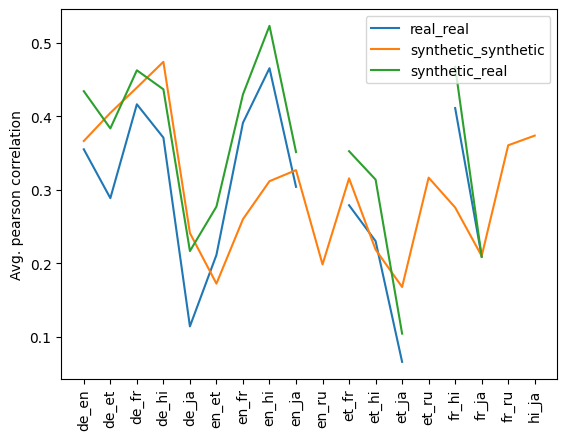

In [22]:
import os 
fig, ax = plt.subplots()

ax.plot(plotting_data.index, plotting_data['real_real'], label='real_real')
ax.plot(plotting_data.index, plotting_data['synthetic_synthetic'], label='synthetic_synthetic')
ax.plot(plotting_data.index, plotting_data['synthetic_real'], label='synthetic_real')
ax.set_xticklabels(plotting_data.index, rotation=90)
ax.set_ylabel('Avg. pearson correlation')
plt.legend()
img_save_path = f'../visuals/north_euralex_concepts/{model_name}/'
os.makedirs(img_save_path, exist_ok=True)
plt.savefig(f'../visuals/north_euralex_concepts/{model_name}/pearson_correlation.jpg', dpi=300, bbox_inches='tight')

**Conclusion.** The fact that real-real always below synthetic-synthetic implies representations more centralized in synthetic space. 

##### Hypothesis 2: synthetic-real will be closer to english across all langs than their own.

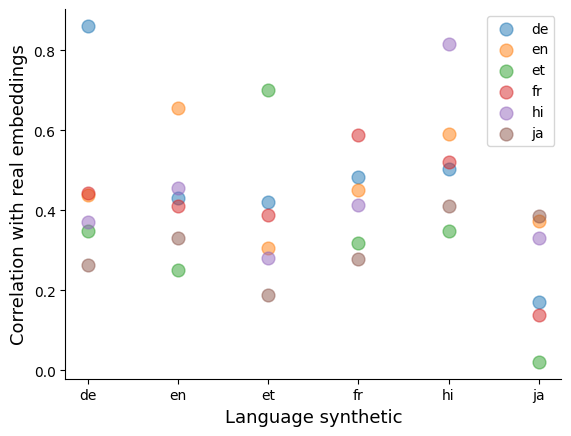

In [23]:
sr = df[df['setting'] == 'synthetic_real']

sr_pivot = sr.pivot(index='lang1', columns='lang2', values='pearson')


cols = sr_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_pivot.index, sr_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend()
plt.savefig(f'../visuals/north_euralex_concepts/{model_name}/synthetic_real_correlation_by_lang.jpg', dpi=300, bbox_inches='tight')


**Normalize the scores by the real-real similarity.** It's feasible, that the languages are not similar. Surprise. So we should adjust by there baseline similarity in the real-real case. 

TODO: consider if we should use the real Wikipedia embeddings to get an estimate of this. 


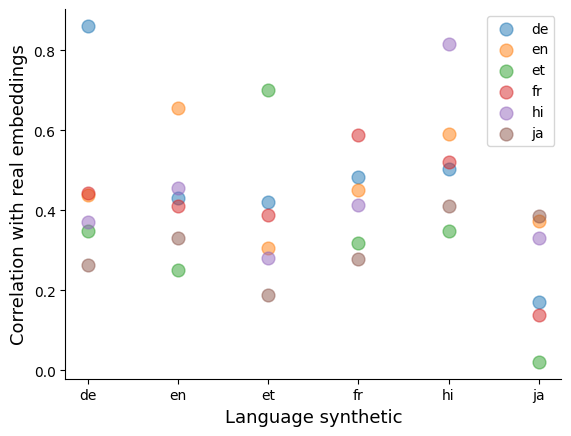

In [24]:
sr = df[df['setting'] == 'synthetic_real']
rr = df[df['setting'] == 'real_real']

sr_m = sr.merge(rr, on=['lang1', 'lang2'], suffixes=('_sr', '_rr'))
sr_m['diff'] = sr_m['pearson_sr'] - sr_m['pearson_rr']

sr_m_pivot = sr_m.pivot(index='lang1', columns='lang2', values='diff')


cols = sr_m_pivot.columns

fig, ax = plt.subplots()
for col in cols:
    sr_pivot[col] 
    ax.scatter(sr_pivot.index, sr_pivot[col], label=col, alpha=0.5, s=85)

ax.spines[['right','top']].set_visible(False)
ax.set_xlabel('Language synthetic', fontsize=13)
ax.set_ylabel("Correlation with real embeddings", fontsize=13)
plt.legend()
plt.savefig(f'../visuals/north_euralex_concepts/{model_name}/synthetic_real_correlation_by_lang_diffed.jpg', dpi=300, bbox_inches='tight')


##### Hypothesis 3: There are structural patterns in terms of how languages differ.

- Compare similarity across different semantic categories. 